<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_40_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [1]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [4]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [5]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [6]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(10),
            nn.ReLU(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [7]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [8]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [9]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 25

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [10]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [11]:
model = Module().to(device)

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

Task 0 Start!
Epoch	1	Acc:  0.7078, Loss:  0.0043
Epoch	2	Acc:  0.8826, Loss:  0.0017
Epoch	3	Acc:  0.9054, Loss:  0.0013
Epoch	4	Acc:  0.9146, Loss:  0.0012
Epoch	5	Acc:  0.9194, Loss:  0.0011
Epoch	6	Acc:  0.9222, Loss:  0.0011
Epoch	7	Acc:  0.9240, Loss:  0.0010
Epoch	8	Acc:  0.9263, Loss:  0.0010
Epoch	9	Acc:  0.9288, Loss:  0.0010
Epoch	10	Acc:  0.9294, Loss:  0.0010
Task 0 Acc:  0.9282, Loss:  0.0010
Task 1 Acc:  0.1255, Loss:  0.0259

Task 1 Start!
Epoch	1	Acc:  0.3515, Loss:  0.0131
Epoch	2	Acc:  0.5584, Loss:  0.0085
Epoch	3	Acc:  0.6075, Loss:  0.0077
Epoch	4	Acc:  0.6280, Loss:  0.0073
Epoch	5	Acc:  0.6393, Loss:  0.0071
Epoch	6	Acc:  0.6466, Loss:  0.0070
Epoch	7	Acc:  0.6518, Loss:  0.0069
Epoch	8	Acc:  0.6552, Loss:  0.0069
Epoch	9	Acc:  0.6569, Loss:  0.0069
Epoch	10	Acc:  0.6585, Loss:  0.0068
Task 0 Acc:  0.7390, Loss:  0.0036
Task 1 Acc:  0.6546, Loss:  0.0048



 - Task 0

Accuracy 0.739
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.81      0.88      0.84       980
     1 - one       0.73      0.99      0.84      1135
     2 - two       0.75      0.58      0.65      1032
   3 - three       0.71      0.78      0.75      1010
    4 - four       0.61      0.79      0.69       982
    5 - five       0.69      0.36      0.47       892
     6 - six       0.81      0.89      0.85       958
   7 - seven       0.92      0.78      0.85      1028
   8 - eight       0.70      0.43      0.54       974
    9 - nine       0.68      0.82      0.74      1009

    accuracy                           0.74     10000
   macro avg       0.74      0.73      0.72     10000
weighted avg       0.74      0.74      0.73     10000



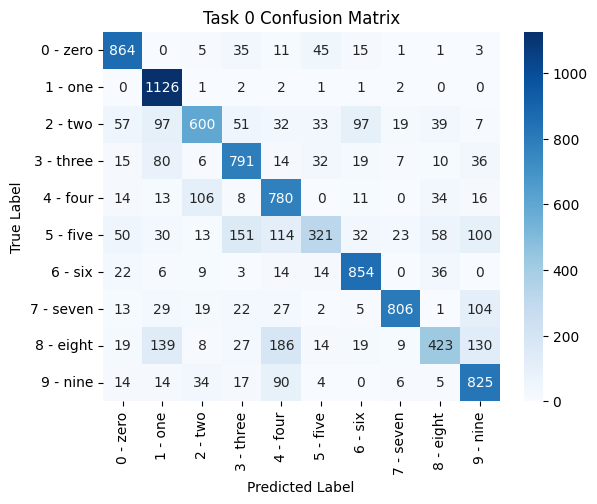

In [12]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.6546
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.71      0.84      0.77       980
     1 - one       0.85      0.83      0.84      1135
     2 - two       0.75      0.46      0.57      1032
   3 - three       0.56      0.61      0.59      1010
    4 - four       0.52      0.47      0.50       982
    5 - five       0.53      0.38      0.44       892
     6 - six       0.78      0.84      0.81       958
   7 - seven       0.66      0.74      0.70      1028
   8 - eight       0.56      0.68      0.61       974
    9 - nine       0.59      0.66      0.62      1009

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.64     10000
weighted avg       0.66      0.65      0.65     10000



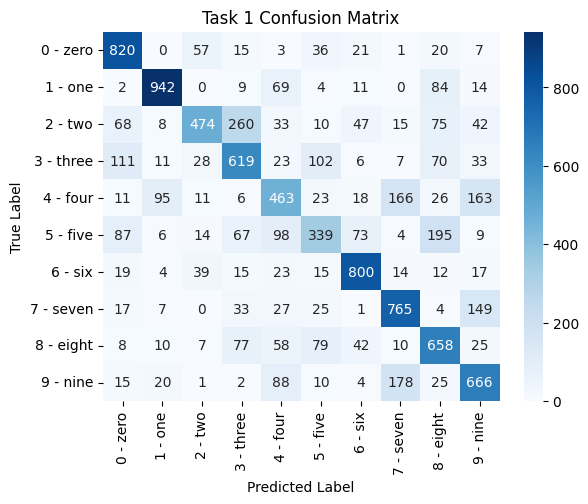

In [13]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.1.weight
torch.Size([10, 784])
Max fisher is 0.08704 and it's parameter diff is 0.00309
Min Parameter diff is 0.97525 and it's fisher is 0.00013
fisher > parameter diff: 257
fisher <= parameter diff: 527


<Figure size 640x480 with 0 Axes>

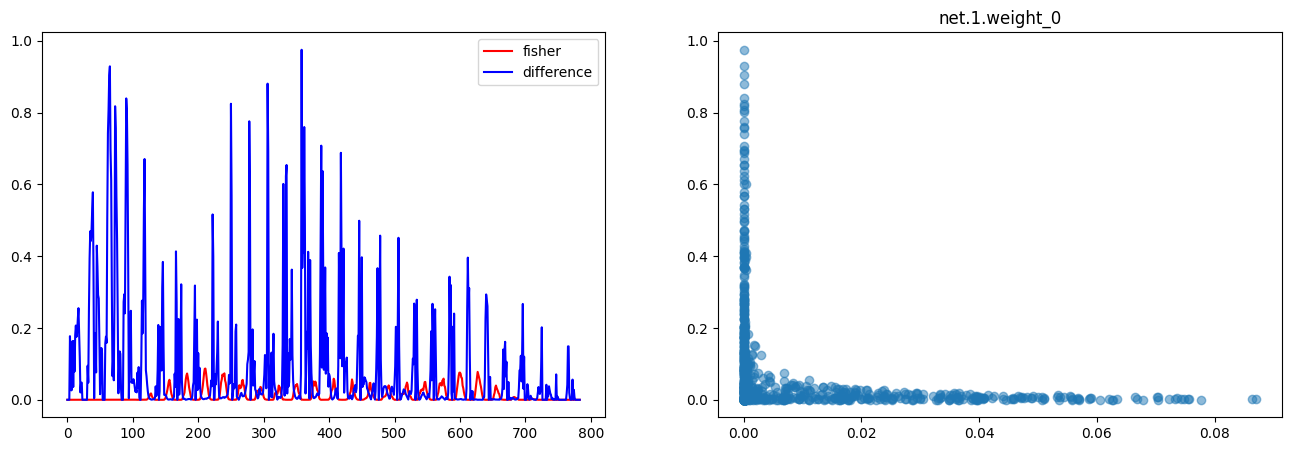

Max fisher is 0.01114 and it's parameter diff is 0.00320
Min Parameter diff is 0.79185 and it's fisher is 0.00002
fisher > parameter diff: 70
fisher <= parameter diff: 714


<Figure size 640x480 with 0 Axes>

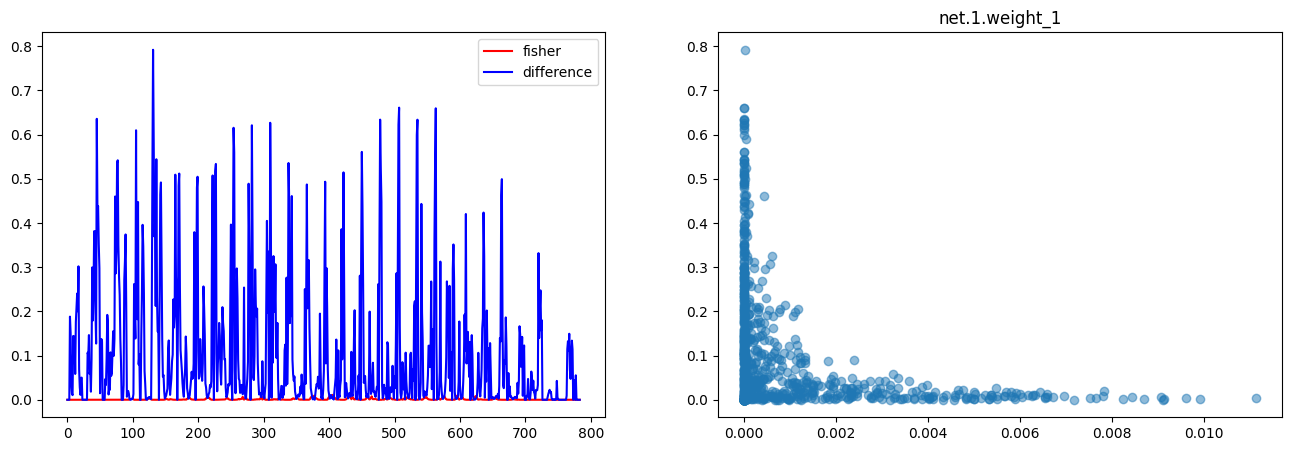

Max fisher is 0.03924 and it's parameter diff is 0.00105
Min Parameter diff is 0.71318 and it's fisher is 0.00003
fisher > parameter diff: 150
fisher <= parameter diff: 634


<Figure size 640x480 with 0 Axes>

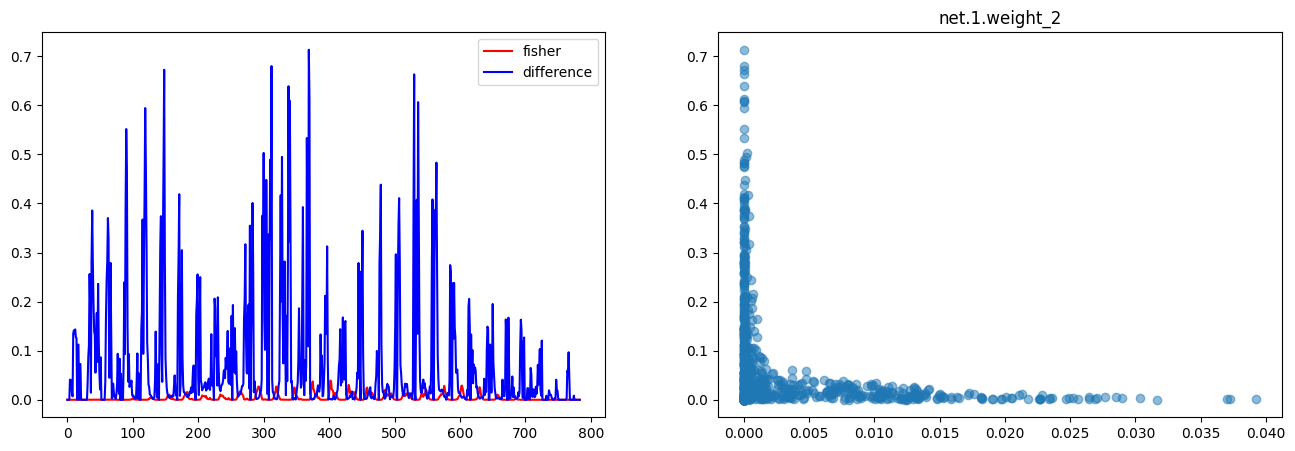

Max fisher is 0.06417 and it's parameter diff is 0.00023
Min Parameter diff is 0.98253 and it's fisher is 0.00000
fisher > parameter diff: 232
fisher <= parameter diff: 552


<Figure size 640x480 with 0 Axes>

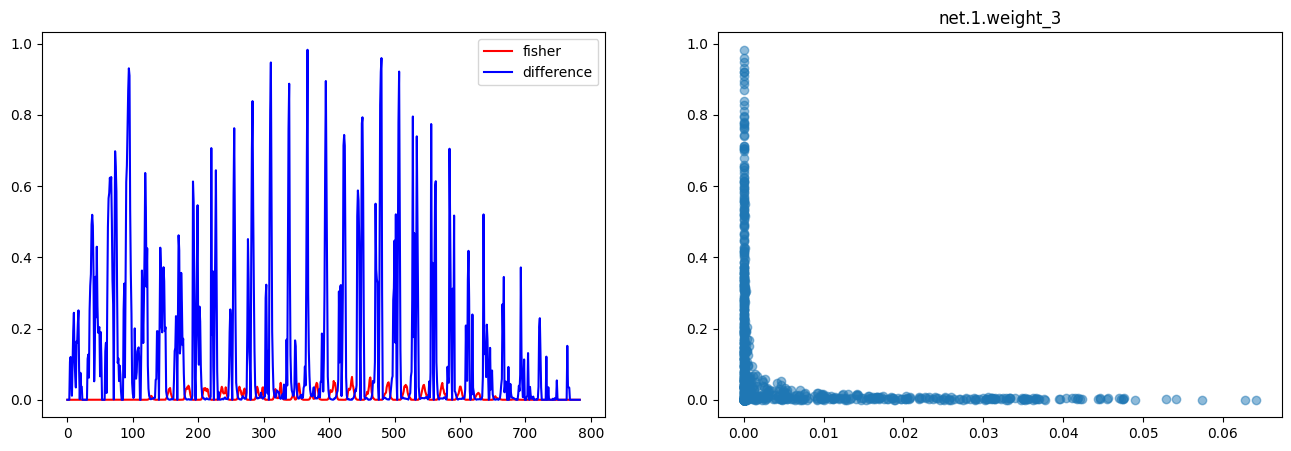

Max fisher is 0.17985 and it's parameter diff is 0.00427
Min Parameter diff is 1.00018 and it's fisher is 0.00000
fisher > parameter diff: 308
fisher <= parameter diff: 476


<Figure size 640x480 with 0 Axes>

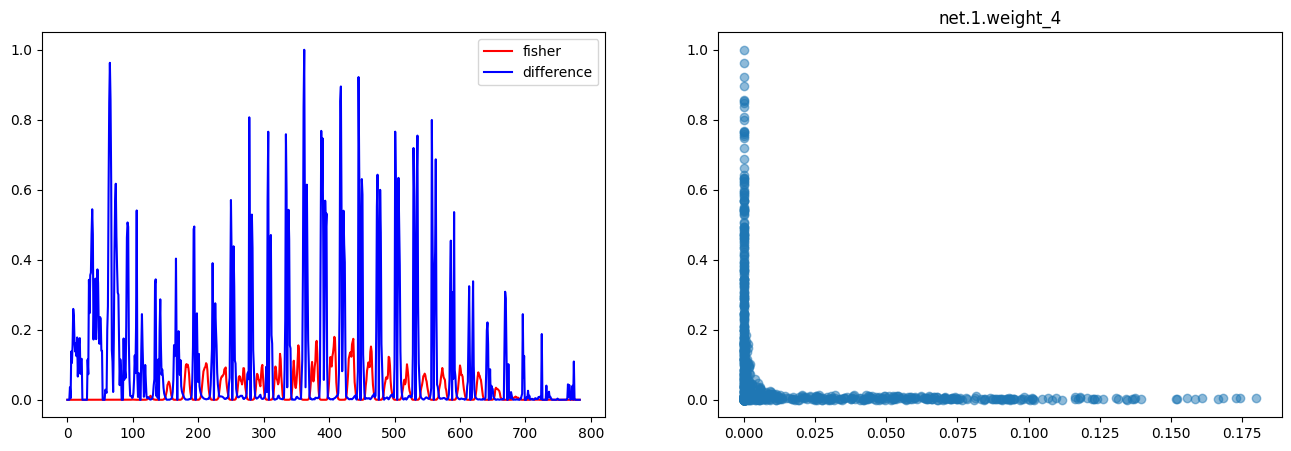

Max fisher is 0.01252 and it's parameter diff is 0.02850
Min Parameter diff is 0.98817 and it's fisher is 0.00019
fisher > parameter diff: 44
fisher <= parameter diff: 740


<Figure size 640x480 with 0 Axes>

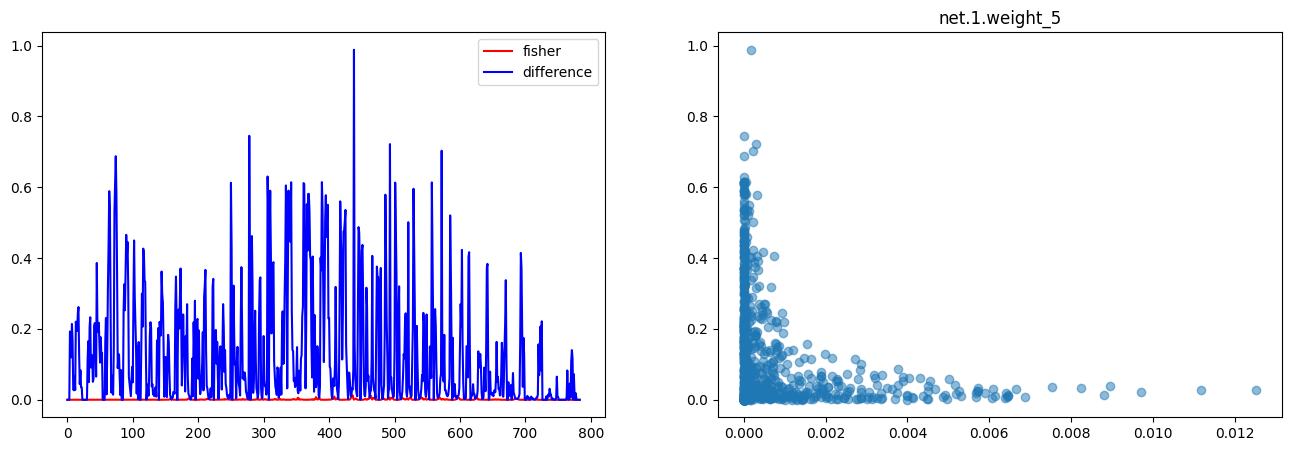

Max fisher is 0.01229 and it's parameter diff is 0.00002
Min Parameter diff is 1.07297 and it's fisher is 0.00001
fisher > parameter diff: 61
fisher <= parameter diff: 723


<Figure size 640x480 with 0 Axes>

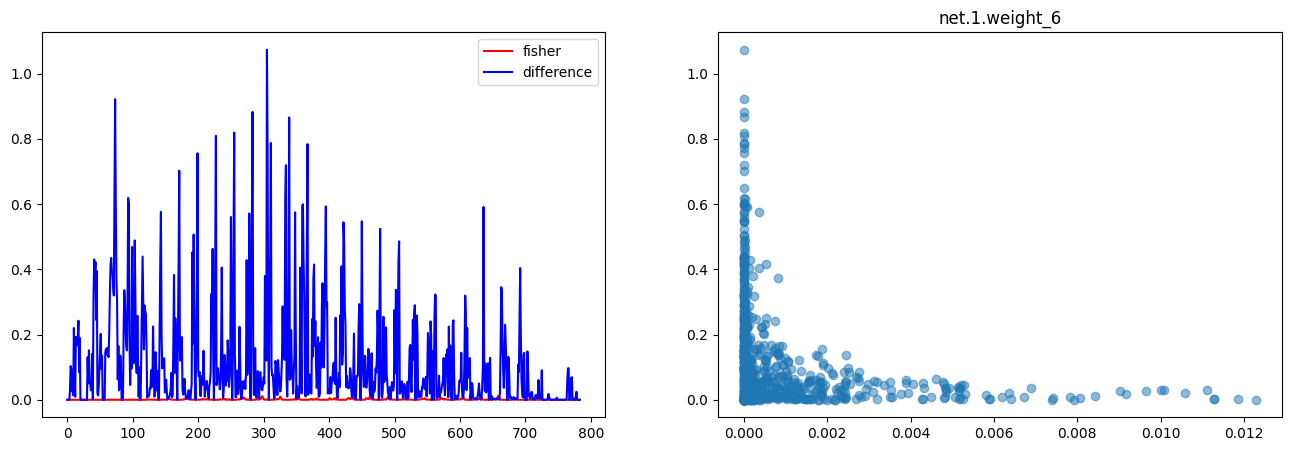

Max fisher is 0.06125 and it's parameter diff is 0.00320
Min Parameter diff is 0.79005 and it's fisher is 0.00000
fisher > parameter diff: 237
fisher <= parameter diff: 547


<Figure size 640x480 with 0 Axes>

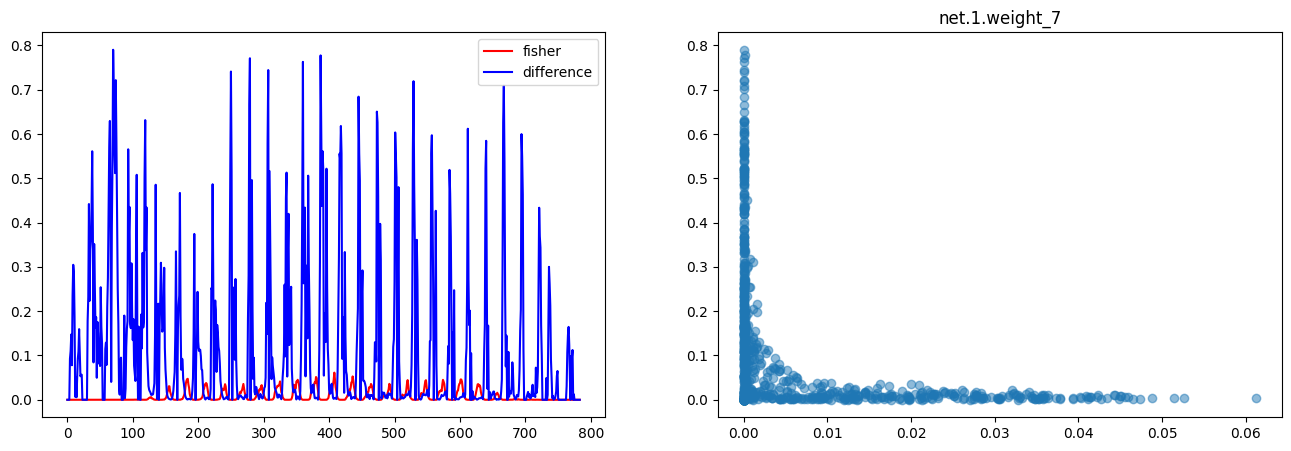

Max fisher is 0.01601 and it's parameter diff is 0.00563
Min Parameter diff is 0.95473 and it's fisher is 0.00000
fisher > parameter diff: 64
fisher <= parameter diff: 720


<Figure size 640x480 with 0 Axes>

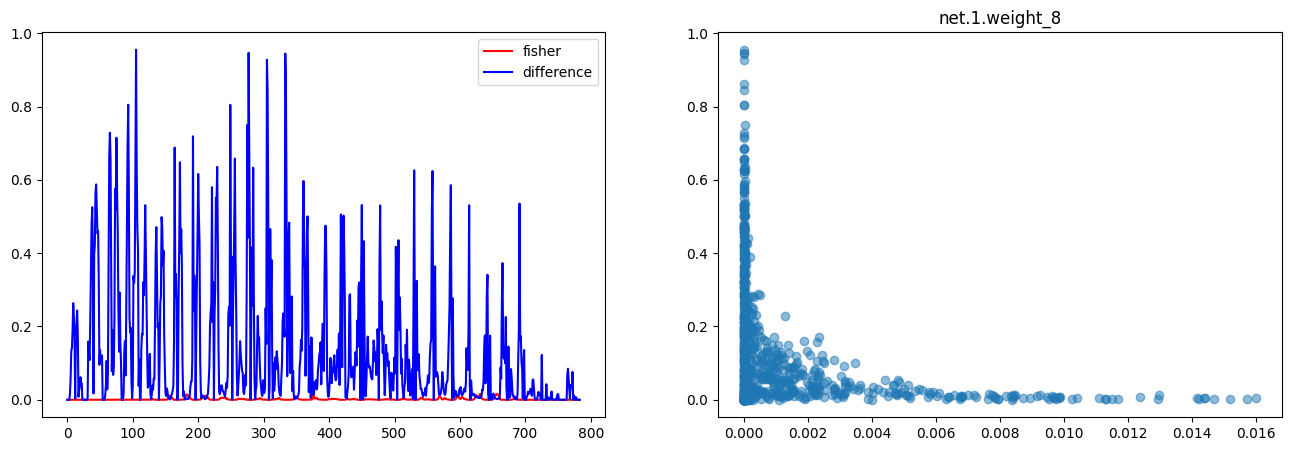

Max fisher is 0.12074 and it's parameter diff is 0.00417
Min Parameter diff is 0.85916 and it's fisher is 0.00000
fisher > parameter diff: 220
fisher <= parameter diff: 564


<Figure size 640x480 with 0 Axes>

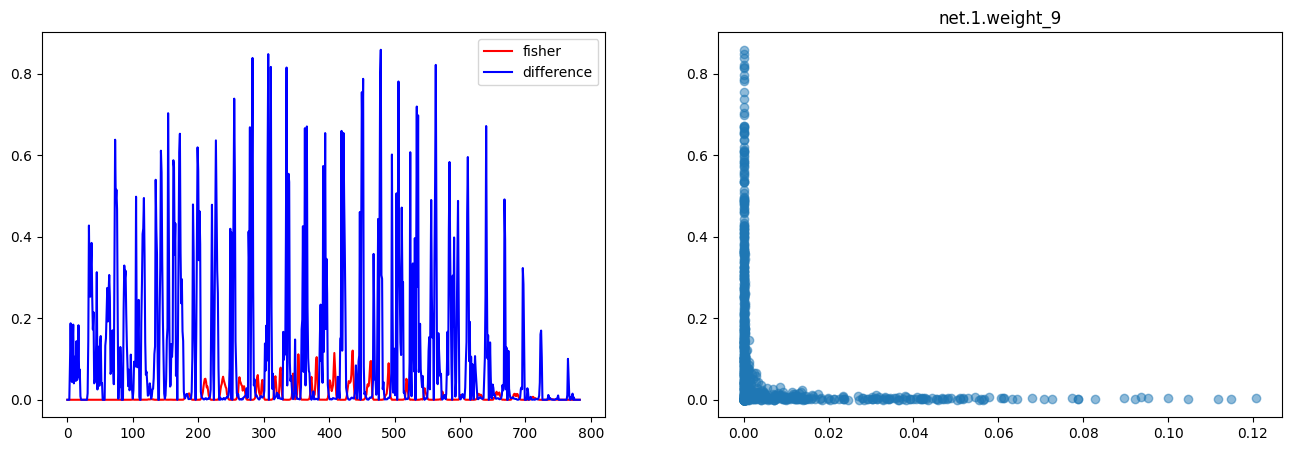


net.1.bias
torch.Size([10])
Max fisher is 0.52838 and it's parameter diff is 0.00051
Min Parameter diff is 0.03573 and it's fisher is 0.00250
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

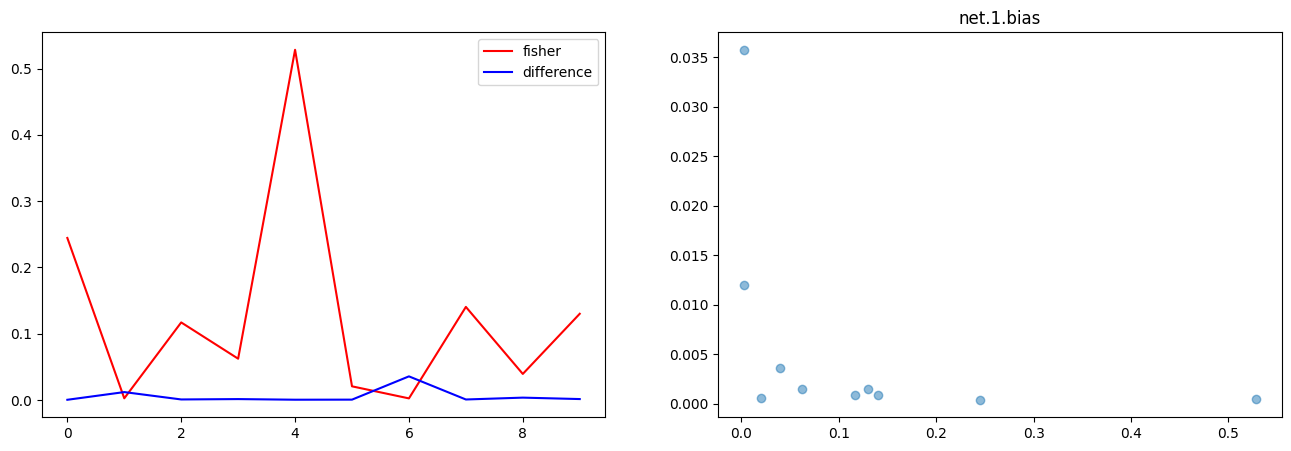


net.3.weight
torch.Size([10, 10])
Max fisher is 1.49528 and it's parameter diff is 0.00285
Min Parameter diff is 0.01900 and it's fisher is 0.00729
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

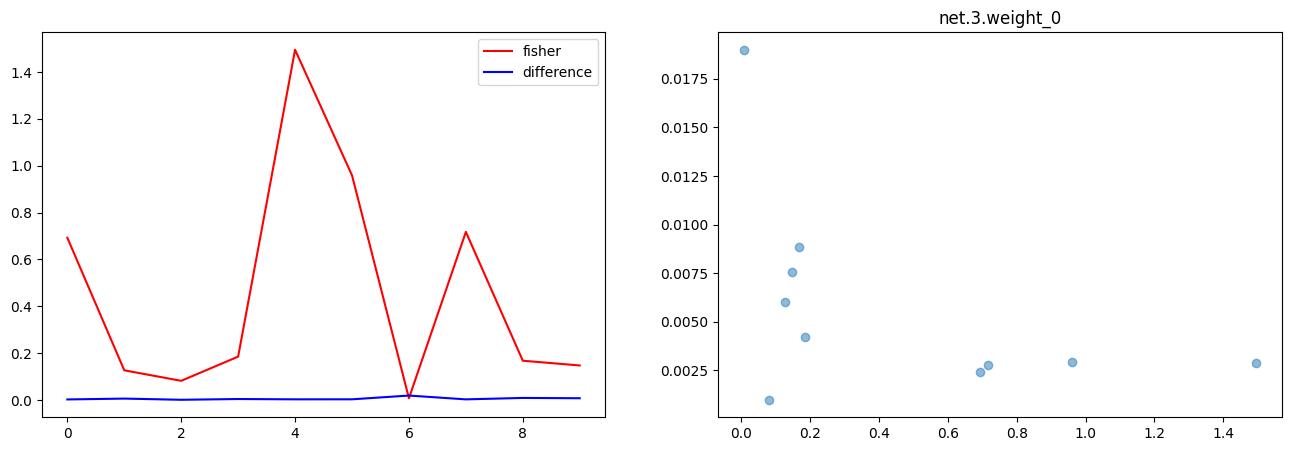

Max fisher is 0.14367 and it's parameter diff is 0.02373
Min Parameter diff is 0.24173 and it's fisher is 0.00907
fisher > parameter diff: 4
fisher <= parameter diff: 6


<Figure size 640x480 with 0 Axes>

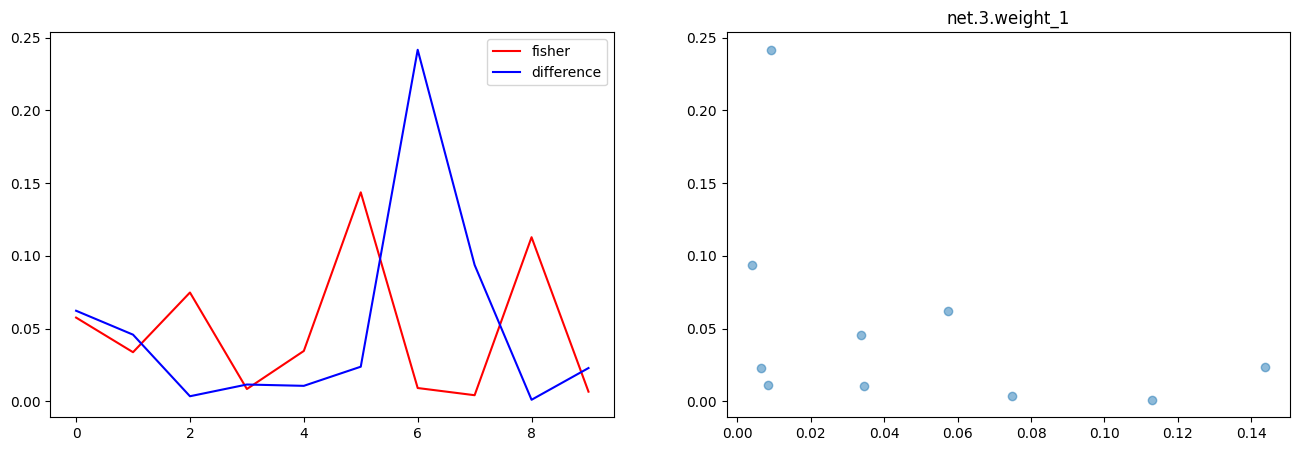

Max fisher is 4.87071 and it's parameter diff is 0.00160
Min Parameter diff is 0.01859 and it's fisher is 0.04895
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

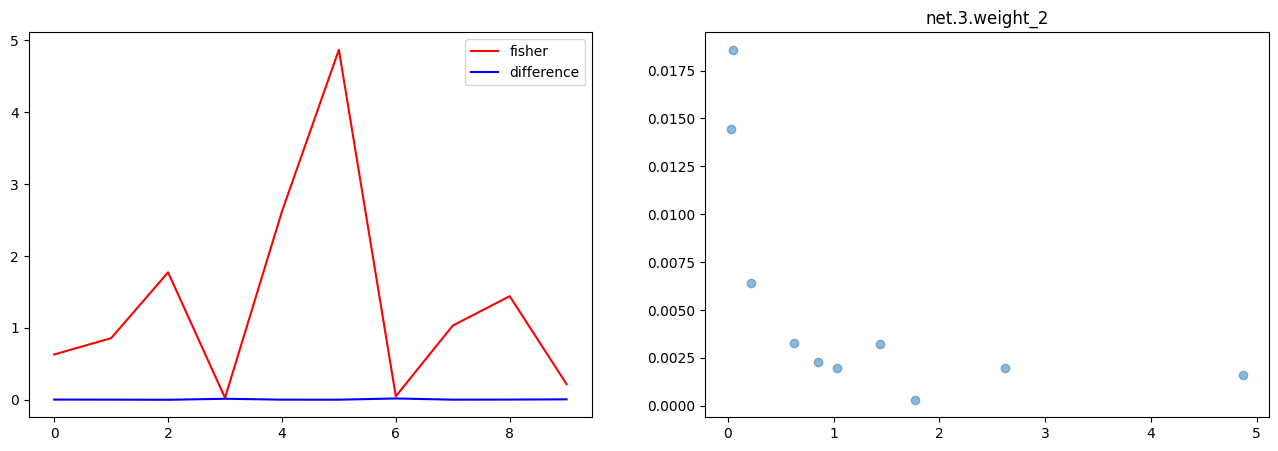

Max fisher is 5.35815 and it's parameter diff is 0.00044
Min Parameter diff is 0.00202 and it's fisher is 0.32423
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

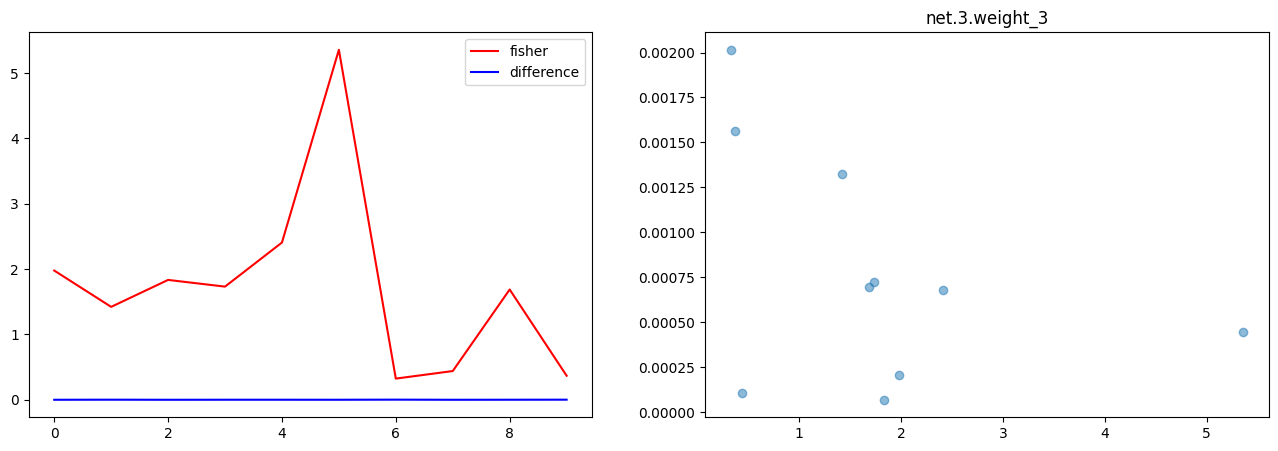

Max fisher is 8.10043 and it's parameter diff is 0.00043
Min Parameter diff is 0.02544 and it's fisher is 0.04230
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

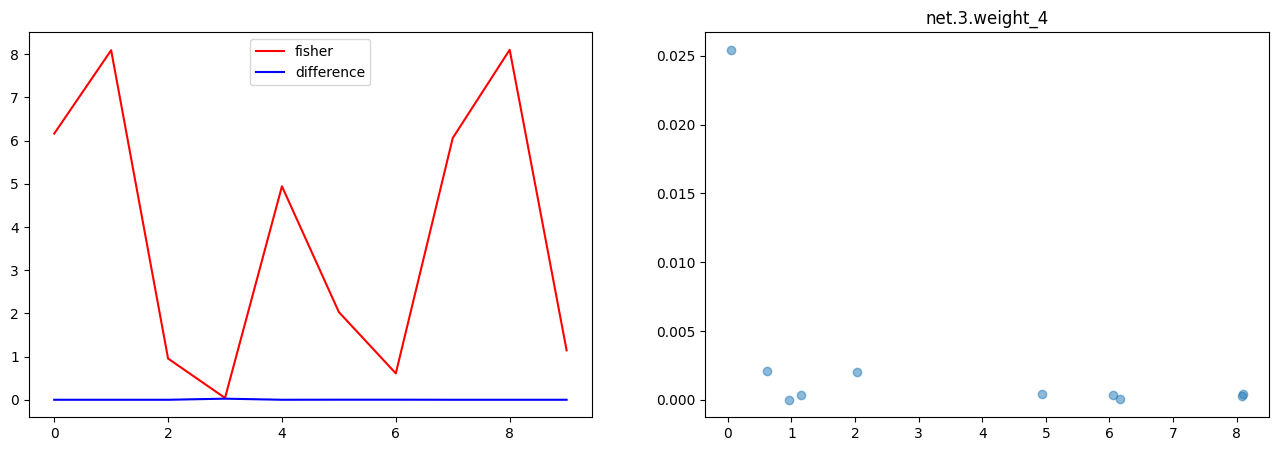

Max fisher is 6.92403 and it's parameter diff is 0.00017
Min Parameter diff is 0.00388 and it's fisher is 0.12185
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

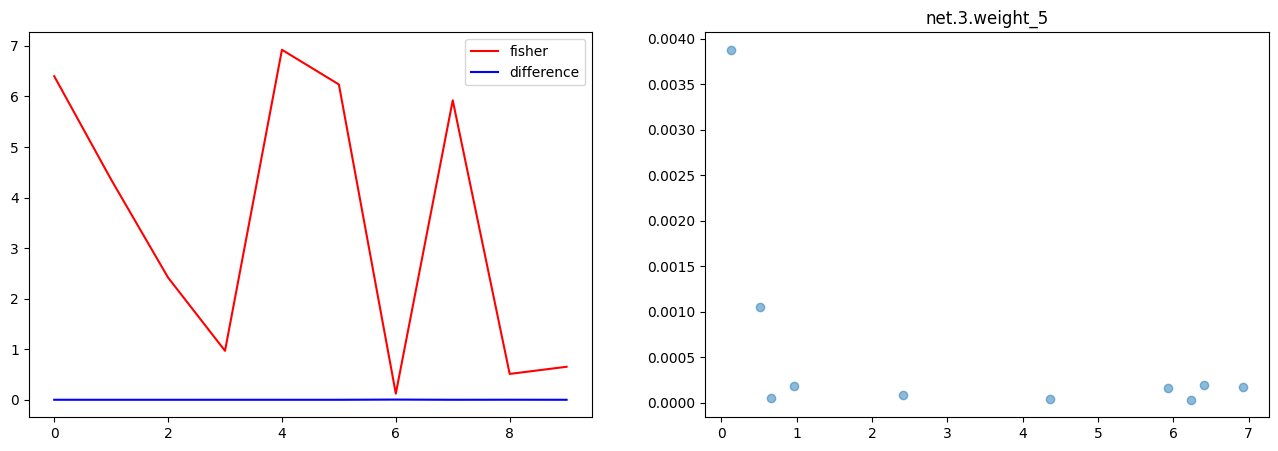

Max fisher is 6.63414 and it's parameter diff is 0.00024
Min Parameter diff is 0.00209 and it's fisher is 0.21289
fisher > parameter diff: 10
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

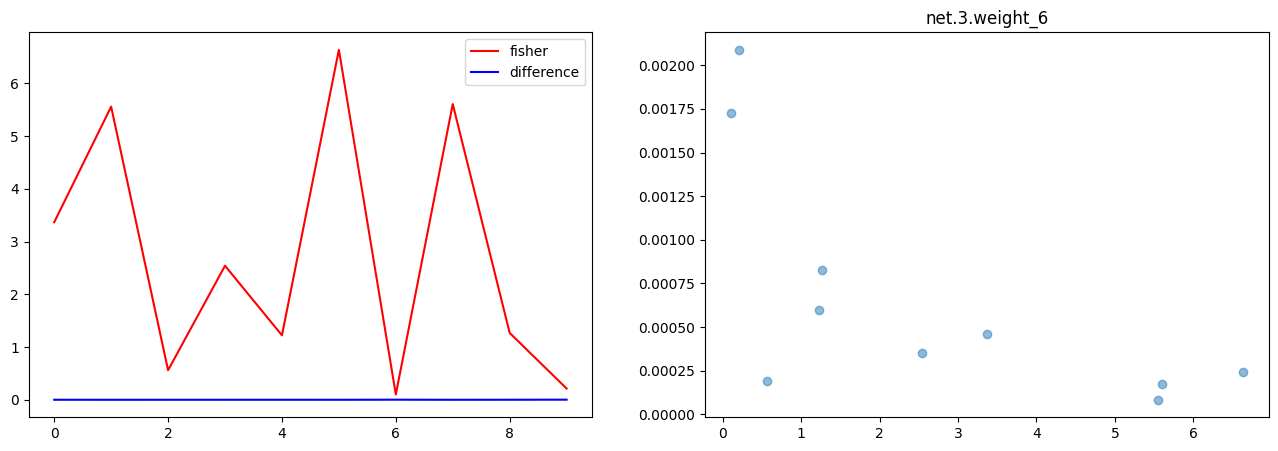

Max fisher is 0.94546 and it's parameter diff is 0.00145
Min Parameter diff is 0.14858 and it's fisher is 0.00320
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

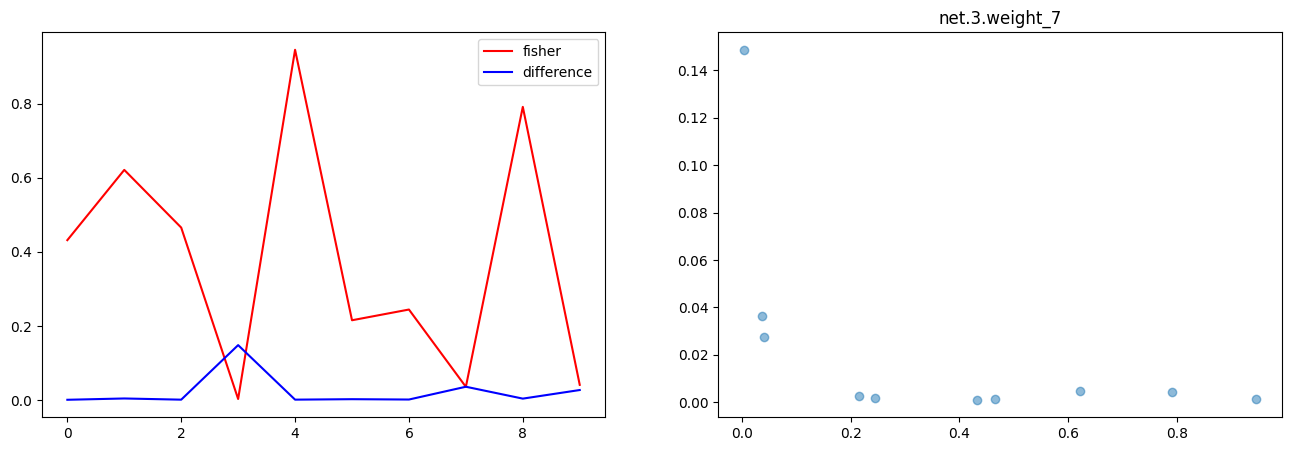

Max fisher is 3.48075 and it's parameter diff is 0.00027
Min Parameter diff is 0.02322 and it's fisher is 0.01923
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

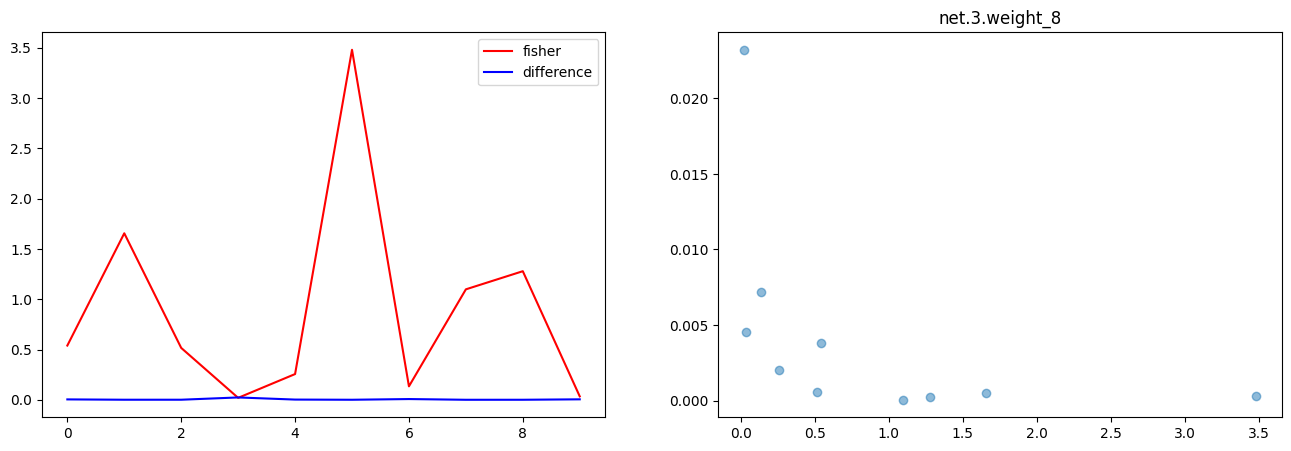

Max fisher is 13.12084 and it's parameter diff is 0.00024
Min Parameter diff is 0.02897 and it's fisher is 0.00867
fisher > parameter diff: 9
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

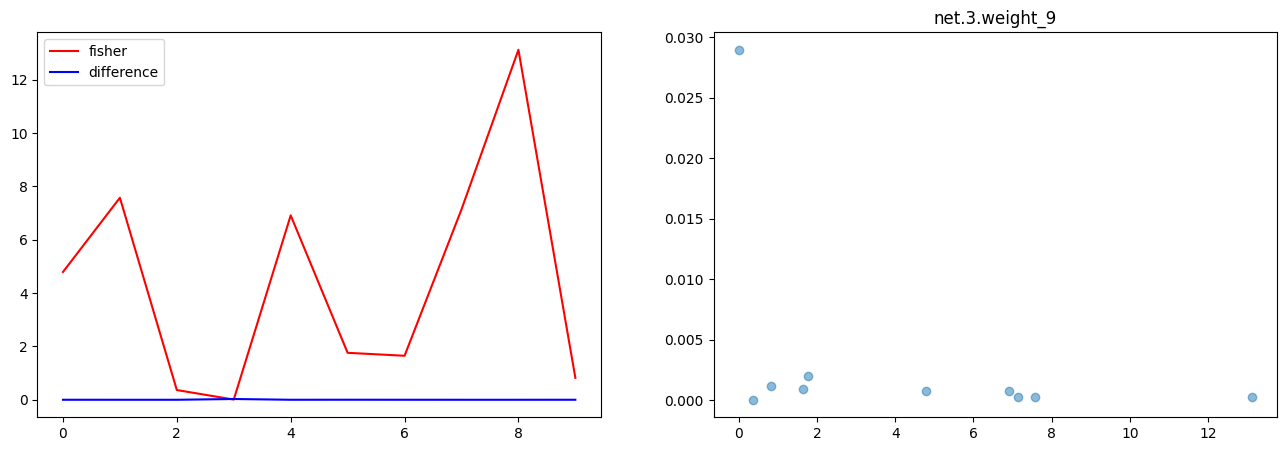


net.3.bias
torch.Size([10])
Max fisher is 0.33326 and it's parameter diff is 0.00081
Min Parameter diff is 0.44521 and it's fisher is 0.00101
fisher > parameter diff: 6
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

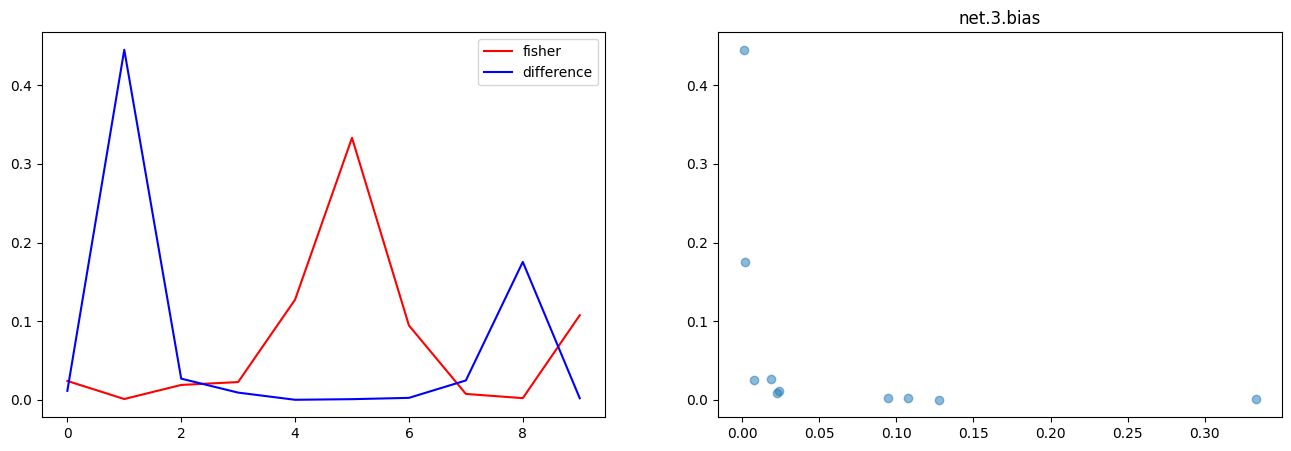

In [14]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i], optim_para[0][name][i], param[i], f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [15]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_12_53_07
